Target:

Get the set-up right
*   Add rotation, of (-7 to 7) degrees.
*   Add StepLR scheduler

Results:

*   Parameters: 7.9k
*   Best training accuracy = 99.30
*   Best Test accuracy = 99.47%

Analysis:

*   Model is awesome!!!
*   No overfittng
*   Target achieved

In [2]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt



## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [3]:
# Train phase transformation

train_transforms = transforms.Compose([transforms.RandomRotation((-7.0, 7.0), fill =(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((.1307,), (.3081,)),
                                       
                                       ])

#Test phase transformation
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((.1307,), (.3081,))
                                       ])

# Download Dataset, apply transforms and Creating Train/Test Split

In [4]:
train_dataset = datasets.MNIST(root= './data', train=True, transform=train_transforms, download=True)
test_dataset = datasets.MNIST(root= './data', train=False, transform=test_transforms, download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Check for device and set SEED value for reproducibility

In [5]:
SEED = 1

#Check for CUDA?
cuda = torch.cuda.is_available()
print("Cuda is available ?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

Cuda is available ? True


# Define Dataloader Arguments & Load Train and Test datasets


DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

In [6]:
# DataLoader arguments
dataloader_args = dict(batch_size=128, shuffle=True, num_workers=4, pin_memory=True) if cuda else dict(batch_size=64, shuffle=True)

# train and test dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [7]:
dir(train_dataset)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 '_format_transform_repr',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'data',
 'download',
 'extra_repr',
 'processed_folder',
 'raw_folder',
 'resources',
 'root',
 'target_transform',
 'targets',
 'test_data',
 'test_file',
 'test_labels',
 'train',
 'train_data',
 'train_labels',
 'training_file',
 'transform',
 'transforms']

In [8]:
print(train_dataset.train_data.shape)
print(train_dataset.train_labels.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [9]:
# # We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train = train_dataset.train_data
# train = train_dataset.transform(train.numpy())  # train.numpy is opposite of transform.ToTensor()


# print('[Train]')
# print(' - Numpy Shape:', train_dataset.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train_dataset.train_data.size())
# print(' - min:', torch.min(train))
# print(' - max:', torch.max(train))
# print(' - mean:', torch.mean(train))
# print(' - std:', torch.std(train))
# print(' - var:', torch.var(train))

# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# #Let's visualize some of the images
# %matplotlib inline

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
# plt.title("Label is: "+str(labels[0].numpy().squeeze()))

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [10]:
# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images):
#   plt.subplot(6, 10, index)
#   plt.axis("off")
#   plt.imshow(images[index].numpy().squeeze(), cmap="gray_r")


# The model
Let's start with the model we first saw


In [11]:
dropout_value = .01
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels= 32,kernel_size= (3, 3), padding=0, bias=False),    #output_image = 26, RF=3
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.Dropout2d(dropout_value)
            )
        
        #Transition BLOCK 1
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels= 8,kernel_size= (1, 1), padding=0, bias=False),    #output_image = 26, RF=3
            nn.ReLU(),
            nn.BatchNorm2d(num_features=8),
            nn.Dropout2d(dropout_value)
        )

        #CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8,out_channels= 10,kernel_size= (3, 3), padding=0, bias=False),    #output_image = 24, RF=5
            nn.ReLU(),
            nn.BatchNorm2d(num_features=10),
            nn.Dropout2d(dropout_value)
        )       
        self.pool1 = nn.MaxPool2d(2, 2)    #output_image = 12, RF=6


        #CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10,out_channels=16 ,kernel_size= (3, 3), padding=1, bias=False),    #output_image = 10, RF=10
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout2d(dropout_value) 
        )
              
        #TRANSITION BLOCK 2 
        self.trans2 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels= 10,kernel_size= (1, 1), padding=0, bias=False),    #output_image = 10, RF=10
            nn.ReLU(),
            nn.BatchNorm2d(num_features=10),
            nn.Dropout2d(dropout_value)
        )

        #CONVOLUTION BLOCK 3
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10,out_channels= 10,kernel_size= (3, 3), padding=0, bias=False),    #output_image = 8, RF=14
            nn.ReLU(),
            nn.BatchNorm2d(num_features=10),
            nn.Dropout2d(dropout_value)
        )       
   
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10,out_channels= 16,kernel_size= (3, 3), padding=0, bias=False),    #output_image = 8, RF=20
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout2d(dropout_value)
        )
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels= 16,kernel_size= (3, 3), padding=0, bias=False),    #output_image = 6, RF=24
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout2d(dropout_value)
        )

    
        #GAP Layer
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6),
            
        )

        # FC layer
        self.trans3 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels= 10,kernel_size= (1, 1), padding=0, bias=False),    #output_image = 6, RF=28
            #nn.ReLU()  NEVER!!!!
            #nn.BatchNorm2d(num_features=10)     NEVER!!!!
            #nn.Dropout2d(dropout_value)    NEVER!!!!
        )
           

    def forward(self, x):
      x = self.convblock1(x)
      x = self.trans1(x)
      x = self.convblock2(x)      
      x = self.pool1(x)
      x = self.convblock3(x)
      x = self.trans2(x)
      x = self.convblock4(x)      
      x = self.convblock5(x)
      x = self.convblock6(x)     
      x = self.gap(x)
      x =self.trans3(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

Summarize Model

In [12]:
from torchsummary import summary
device = torch.device("cuda" if cuda else "cpu")

model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
       BatchNorm2d-3           [-1, 32, 26, 26]              64
         Dropout2d-4           [-1, 32, 26, 26]               0
            Conv2d-5            [-1, 8, 26, 26]             256
              ReLU-6            [-1, 8, 26, 26]               0
       BatchNorm2d-7            [-1, 8, 26, 26]              16
         Dropout2d-8            [-1, 8, 26, 26]               0
            Conv2d-9           [-1, 10, 24, 24]             720
             ReLU-10           [-1, 10, 24, 24]               0
      BatchNorm2d-11           [-1, 10, 24, 24]              20
        Dropout2d-12           [-1, 10, 24, 24]               0
        MaxPool2d-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1, 16,

Training and Testing functions

In [13]:
from tqdm import tqdm
import os
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  train_acc = 0
  correct = 0
  processed = 0

  pbar = tqdm(train_loader, position=0, leave=True)

  for batch_idx, (images, labels) in enumerate(pbar):
    # get samples
    images, labels = images.to(device), labels.to(device)
    # Init
    optimizer.zero_grad()
    #Predict
    y_pred = model(images)
    #Calculate loss
    loss = F.nll_loss(y_pred, labels)
    train_losses.append(loss)

    #Backpropagation
    loss.backward()

    #update weights
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

    #check how many predictions are correct
    if cuda:
      correct += pred.cpu().eq(labels.cpu().view_as(pred)).sum().item()
    else:
      correct += pred.eq(labels.view_as(pred)).sum().item()
    
    processed += len(images) # 128 + 128 +128 ......till 60000 images

    train_acc = 100*correct / processed
    
    pbar.set_description(desc=f"EPOCH= {epoch} Loss= {loss.item() :0.4f} Batch_id= {batch_idx} Accuracy= {train_acc:0.2f}")
    train_accuracy.append(train_acc)
    
    
def test(model, device, test_loader):
  model.eval()
  
  test_acc = 0
  correct = 0
  test_loss = 0
  
  with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
      # get samples
      images, labels = images.to(device), labels.to(device)      
      #Predict
      y_pred = model(images)
      #Calculate loss and sum all the loss for one batch
      test_loss += F.nll_loss(y_pred, labels, reduction='sum').item()    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      #check how many predictions are correct
      if cuda:
        correct += pred.cpu().eq(labels.cpu().view_as(pred)).sum().item()
      else:
        correct += pred.eq(labels.view_as(pred)).sum().item()
          
  test_loss /= len(test_loader.dataset)  # loss per epoch
  test_losses.append(test_loss)

  test_acc = 100.*correct / len(test_loader.dataset)
  
  print(f"\nTest set: Average Loss= {test_loss :0.4f} Batch_id= {batch_idx} Accuracy= {correct}/{len(test_loader.dataset)} ({test_acc:0.2f}%)\n")
  test_accuracy.append(test_acc)



In [17]:
from torch.optim.lr_scheduler import StepLR
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
  train(model, device, train_loader, optimizer, epoch)
  scheduler.step()
  test(model, device, test_loader)

EPOCH= 0 Loss= 0.0356 Batch_id= 468 Accuracy= 98.70: 100%|██████████| 469/469 [00:15<00:00, 30.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0237 Batch_id= 78 Accuracy= 9917/10000 (99.17%)



EPOCH= 1 Loss= 0.0199 Batch_id= 468 Accuracy= 98.86: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0206 Batch_id= 78 Accuracy= 9939/10000 (99.39%)



EPOCH= 2 Loss= 0.0586 Batch_id= 468 Accuracy= 98.84: 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0237 Batch_id= 78 Accuracy= 9920/10000 (99.20%)



EPOCH= 3 Loss= 0.0963 Batch_id= 468 Accuracy= 98.94: 100%|██████████| 469/469 [00:15<00:00, 31.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0192 Batch_id= 78 Accuracy= 9933/10000 (99.33%)



EPOCH= 4 Loss= 0.0846 Batch_id= 468 Accuracy= 98.84: 100%|██████████| 469/469 [00:15<00:00, 30.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0223 Batch_id= 78 Accuracy= 9933/10000 (99.33%)



EPOCH= 5 Loss= 0.0223 Batch_id= 468 Accuracy= 98.97: 100%|██████████| 469/469 [00:15<00:00, 31.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0203 Batch_id= 78 Accuracy= 9938/10000 (99.38%)



EPOCH= 6 Loss= 0.0485 Batch_id= 468 Accuracy= 98.99: 100%|██████████| 469/469 [00:15<00:00, 31.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0207 Batch_id= 78 Accuracy= 9932/10000 (99.32%)



EPOCH= 7 Loss= 0.0216 Batch_id= 468 Accuracy= 99.14: 100%|██████████| 469/469 [00:15<00:00, 31.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0171 Batch_id= 78 Accuracy= 9945/10000 (99.45%)



EPOCH= 8 Loss= 0.0141 Batch_id= 468 Accuracy= 99.31: 100%|██████████| 469/469 [00:15<00:00, 30.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0175 Batch_id= 78 Accuracy= 9947/10000 (99.47%)



EPOCH= 9 Loss= 0.0149 Batch_id= 468 Accuracy= 99.25: 100%|██████████| 469/469 [00:15<00:00, 30.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0165 Batch_id= 78 Accuracy= 9946/10000 (99.46%)



EPOCH= 10 Loss= 0.0073 Batch_id= 468 Accuracy= 99.25: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0169 Batch_id= 78 Accuracy= 9943/10000 (99.43%)



EPOCH= 11 Loss= 0.0664 Batch_id= 468 Accuracy= 99.22: 100%|██████████| 469/469 [00:14<00:00, 31.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0169 Batch_id= 78 Accuracy= 9945/10000 (99.45%)



EPOCH= 12 Loss= 0.0069 Batch_id= 468 Accuracy= 99.30: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0165 Batch_id= 78 Accuracy= 9942/10000 (99.42%)



EPOCH= 13 Loss= 0.0074 Batch_id= 468 Accuracy= 99.30: 100%|██████████| 469/469 [00:15<00:00, 31.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0161 Batch_id= 78 Accuracy= 9945/10000 (99.45%)



EPOCH= 14 Loss= 0.0244 Batch_id= 468 Accuracy= 99.29: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]



Test set: Average Loss= 0.0160 Batch_id= 78 Accuracy= 9946/10000 (99.46%)



In [15]:
print(len(train_losses))
print("************")
print(len(test_losses))
print("************")
print(len(train_accuracy))
print("************")
print(len(test_accuracy))

7035
************
15
************
7035
************
15


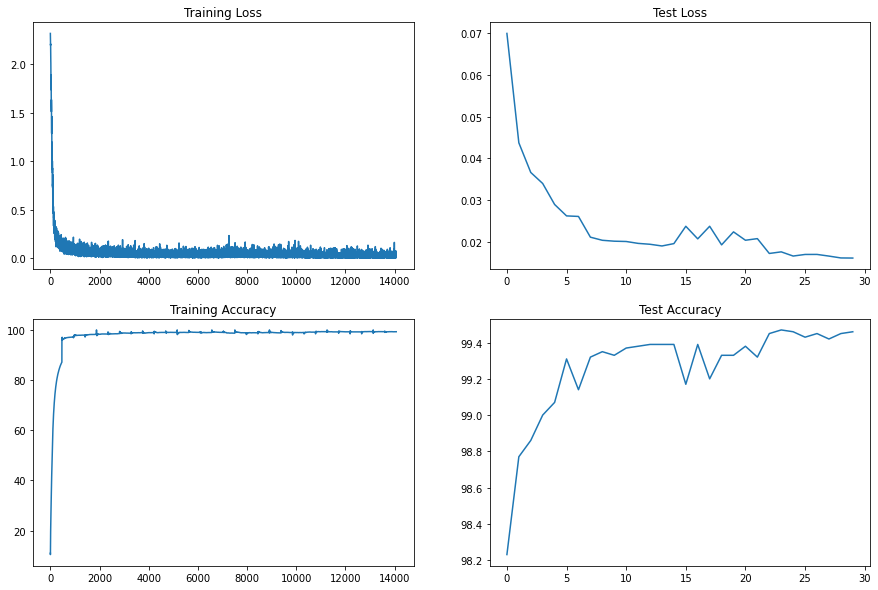

In [21]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracy)
axs[1, 1].set_title("Test Accuracy")
plt.show()
fig.savefig('Loss_and_accuracy_plot.png')